# DCGAN for brain Image data

# GAN: Generative Adverserial Networks


Big Picture Process:

1. Generator generates a random image of the size similar to the training data based on a random seed.
2. Discriminator checks if the input image from generator is real or fake.
3. Outputs from discriminator are taken as loss function for generator. Using these results from the discriminator outputs, Generator trains itself.
4. Combiner helps in the whole process by stacking up generator and discriminator as one black box. it takes noise as input => generates images => determines validity.
5. When Generator is trained, Discriminator is static. When Discriminator is trained, Generator is static.
6. Finally after training enough, the generator is able to create images that are very similar to the training data. The discriminator is unable to distinguish between the training data and the fake ones created by generator. 



In [1]:
# loading the modules

import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf  

In [2]:
# Add image helper module

import image_helper as helper

## Loading the images from folder

### set data directory here.

### params

data_dir: data direcotry. set imput folder path here.

img_format = format of the image. default 'png'

imagecount = count of the images to be loaded.

tensor = Bool to get the output object as Tensor object. Default: True. If False, it returns Numpy NDarray

In [3]:
import image_helper as helper
dir_data      = "H://PatternLab//PatternRecognition//Datasets//brain//keras_png_slices_data//keras_png_slices_train"
Ntrain        = 50
img_shape     = (128, 128, 1)
X_train = helper.tf_load_img_from_dir(dir_data,  imagecount = Ntrain)

In [4]:
X_train.shape


(50, 256, 256, 1)

In [5]:
from image_helper import tf_plot_gallery as plot_gallery

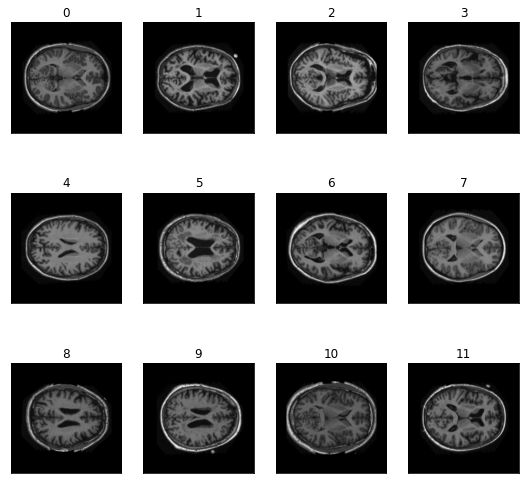

In [6]:
plot_gallery(X_train,128,128)

In [9]:
X_train[0].shape


(256, 256, 1)

In [ ]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

## optimizer
#optimizer = Adam(0.0002, 0.5)
optimizer = Adam(0.00007, 0.5)

def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128*8*8, activation="relu")(d)
    d = layers.Reshape((8,8,128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
    if img_shape[0] == 64:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
    if img_shape[0] == 128:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
        
        d = layers.Conv2DTranspose(64, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D( 128  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_7")(d) ## 128,128
        
     
       
    img = layers.Conv2D( 1 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(d) ## 128 x 128
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img, cmap = 'gray')
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 6
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

In [ ]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = optimizer,
                      metrics   = ['accuracy'])

discriminator.summary()

In [ ]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

In [ ]:
def train(models, X_train, noise_plot, dir_result="/result/", epochs=10, batch_size=128):
        '''
        models     : tuple containins three tensors, (combined, discriminator, generator)
        X_train    : np.array containing images (Nsample, height, width, Nchannels)
        noise_plot : np.array of size (Nrandom_sample_to_plot, hidden unit length)
        dir_result : the location where the generated plots for noise_plot are saved 
        
        '''
        combined, discriminator, generator = models
        nlatent_dim = noise_plot.shape[1]
        half_batch  = int(batch_size / 2)
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = get_noise(half_batch, nlatent_dim)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            
            # Train the discriminator q: better to mix them together?
            # train_on_batch method: Runs a single gradient update on a single batch of data.
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = get_noise(batch_size, nlatent_dim)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            history.append({"D":d_loss[0],"G":g_loss})
            
            if epoch % 50 == 0:
                # Plot the progress
                print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
                    epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % int(epochs/50) == 0:
                plot_generated_images(noise_plot,
                                      path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                      titleadd="Epoch {}".format(epoch))
            if epoch % 50 == 0:
                plot_generated_images(noise_plot,
                                      titleadd="Epoch {}".format(epoch))
                        
        return(history)

dir_result="./result_GAN/"

try:
    os.mkdir(dir_result)
except:
    pass
    
start_time = time.time()

_models = combined, discriminator, generator          

history = train(_models, X_train, noise, dir_result=dir_result,epochs=500, batch_size=10)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))